# Mildew cucumber models
Below are the different models used to calculate the risk of mildew appearance. 

First we will show the results we have with the FieldClimate site, Pessl chose to use the model "Blight by Phythopthora infestans" also used for potato mildew.

Afterwards we will show the results with our implementation of the models:

- Homemade model based on Pessl results
- NegFry : model also used for potato
- A model from a study in North and South Carolina, USA

Let's start by reading the data we extracted from the FieldClimate site in the "Wolf Biogemuse" station, or from the data agroscope gave us. 

For the Wolf station, we extracted the hourly data from July 1 to September 4. The last few days are not important because it was around these dates that they stopped the sensors. All the data are coming from the sensors except for the "disease_severity" and "spraying_interval", these two comes from the Pessl model based on the other datas.

For the agroscope data, there is 4 sheets of data. The data contains the hourly value for the air temperature and the percent of humidity. 

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Change to 'wolf' if you want the FieldClimate data, change to 'agroscope' if you want their data.
station = 'agroscope'  # 'agroscope' or 'wolf'

# Read excel, sort data by date
dfs = pd.read_excel("data_"+station+".xls", engine='xlrd', sheet_name=None)

plt.rcParams['figure.figsize'] = [20, 10]

for i, df in dfs.items():
    df.sort_values(by=["date"], inplace=True)
    # Show columns
    print("Sheet", i, ": Number of element (hours): ",
          df["date"].size, "\nColumns: ", df.columns)


Sheet h3_cult_1 : Number of element (hours):  2040 
Columns:  Index(['date', 'date-end', 'air_temp_celsius_avg', 'percent_humidity_avg'], dtype='object')
Sheet h3_cult_2 : Number of element (hours):  1741 
Columns:  Index(['date', 'date-end', 'air_temp_celsius_avg', 'percent_humidity_avg'], dtype='object')
Sheet h4_cult_1 : Number of element (hours):  2040 
Columns:  Index(['date', 'date-end', 'air_temp_celsius_avg', 'percent_humidity_avg'], dtype='object')
Sheet h4_cult_2 : Number of element (hours):  1741 
Columns:  Index(['date', 'date-end', 'air_temp_celsius_avg', 'percent_humidity_avg'], dtype='object')


## Plot function

Function that plots the dataframe received for the columns mentionned.

In [165]:
def plot_dfs(dfs, x, y):

    # if no data, return
    if(len(dfs) == 0):
        return
        
    # if only 1 data, display it without subplot    
    if(len(dfs) == 1):
        first_pair = next(iter((dfs.items())))
        plot = first_pair[1].plot(title="Sheet "+str(first_pair[0]), x=x, y=y, rot=80)
        return
        
    # Define row and col and subplot
    nrow = int(len(dfs) / 2 + 0.5)
    ncol = 2
    fig, axes = plt.subplots(nrow, ncol)
    fig.tight_layout(h_pad=10)

    r = 0, c = 0
    for i, df in dfs.items(): # iterate over each data and display the column asked for (y)
        if nrow > 1:
            plot = df.plot(title="Sheet "+str(i), x=x, y=y, rot=80, ax=axes[r, c])
        else:
            plot = df.plot(title="Sheet "+str(i), x=x, y=y, rot=80, ax=axes[c])

        # Adjust date label
        xdate = [item.get_text()[:10]
                 for item in plot.get_xticklabels()]
        _ = plot.set_xticklabels(xdate)

        # Increment row/col
        c += 1
        if c > 1:
            r += 1
            c = 0
        


SyntaxError: cannot assign to literal (2601210581.py, line 19)

## Results from FieldClimate
Results with the model "Blight by Phythopthora infestans" from Pessl if present

In [ ]:
dfs_pessl = {}

for i, df in dfs.items():
    if 'disease_severity' in df:
        dfs_pessl[i] = df
    else:
        print("no data from pessl in sheet", i)


# Plot Pessl if present
if len(dfs_pessl) > 0:
    plot_dfs(dfs_pessl, x="date", y="disease_severity")

no data from pessl in sheet h3_cult_1
no data from pessl in sheet h3_cult_2
no data from pessl in sheet h4_cult_1
no data from pessl in sheet h4_cult_2


## Homemade replicate of Pessl model
As an experience I tryed to replicate Pessl algorithm:

- Calculate consecutive hours where: RH > 80 and air temperature < 28
- We relate the consecutive hours to the severity:
  - From 9h to 11h => 1
  - From 12h to 14h => 2
  - From 15h to 17h => 3
  - From 18h to 20h => 4
  - From 21h to 23h => 5
  - \> 24h => 6

These simple conditions are enough to almost replicate their algorithm.

Note: Since I'm not an expert at all, this model is only based on my observation, it's probably worth nothing

2


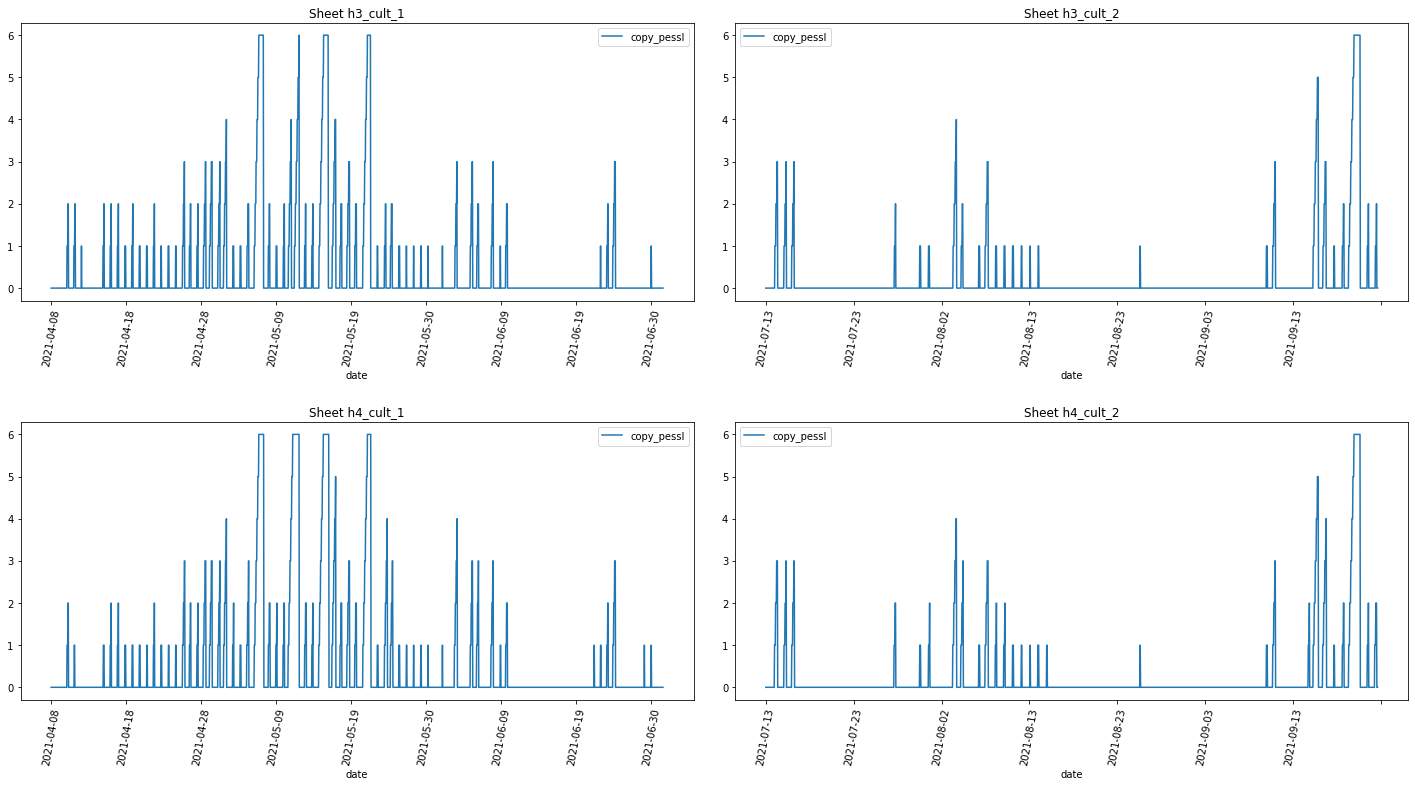

In [ ]:
def copy_pessl_model(df):
    df['copy_pessl'] = 0  # add column for our results

    consecutive = 0
    for i, row in df.iterrows():
        consecutive += 1

        # condution to restart the streak
        if row['air_temp_celsius_avg'] > 27 or row['percent_humidity_avg'] < 80:
            consecutive = 0
            continue

        # condition according to consecutive hours
        if consecutive > 24:
            df.at[i, 'copy_pessl'] = 6
        elif consecutive > 21:
            df.at[i, 'copy_pessl'] = 5
        elif consecutive > 18:
            df.at[i, 'copy_pessl'] = 4
        elif consecutive > 15:
            df.at[i, 'copy_pessl'] = 3
        elif consecutive > 12:
            df.at[i, 'copy_pessl'] = 2
        elif consecutive > 9:
            df.at[i, 'copy_pessl'] = 1

for i, df in dfs.items():
    copy_pessl_model(df)  # call model for each data

# Plot the copy of Pessl algorithm
plot_dfs(dfs, x="date", y="copy_pessl")


## NegFry model
Implementation of this table:

| Index (i) | Multiplication factor (r) | Nombre d'heures où les températures moyennes horaires se situent dans cette plage (h), où d'autres conditions (RH>90% ou pluie ≥ 0.1mm/h) doivent être remplies pour les index 1 à12.  || Exigences relatives à l'HR ou aux précipitations, ou autres conditions à respecter  | Calcul Index du risque selon l'ex.  |
| --- | --- | --- | --- | --- | --- |
||| Gamme de T°C | Ex. de valeurs (nb d'heures) |||
| 1 | 0.899 | 10.0 - 11.9 | 1 | Only count hours that co-occur with 4 or more consecutive hours at RH>=90% or rain≥0.1 mm/heure (h1 to h6) | 0 |
| 2 | 0.4118 | 14.0 - 15.9 | 5 || 2 |
| 3 | 0.5336 | 16.0 - 17.9 | 2 || 0 |
| 4 | 0.8816 | 18.0 - 19.9 | 12 || 11 |
| 5 | 1.0498 | 20.0 - 21.9 | 8 || 8 |
| 6 | 0.5858 | 22.0 - 23.9 | 0 || 0 |
| 7 | 0.3924 | 10.0 - 11.9 | 0 | Only count hours that co-occur with 10 or more consecutive hours at RH>=90% or rain≥0.1 mm/heure (h7 to h12) | 0 |
| 8 | 0.0702 | 14.0 - 15.9 | 0 || 0 |
| 9 | 0.1278 | 16.0 - 17.9 | 1 || 0 |
| 10 | 0.9108 | 18.0 - 19.9 | 12 || 11 |
| 11 | 1.4706 | 20.0 - 21.9 | 10 || 15 |
| 12 | 0.855 | 22.0 - 23.9 | 5 || 0 |
| 13 | 0.1639 | 15.0 - 19.9 | 14 | Do not consider RH or rain, add 7.5479 to the product of r x h | 10 |
| 14 | 0.0468 | Number of hours with average RH < 70% | 4 | Subtract 7.8624 from the product of r x h | 0 |
||||| Valeur du risqué de mildiou (VRM) : somme des valeurs | 57 |

2


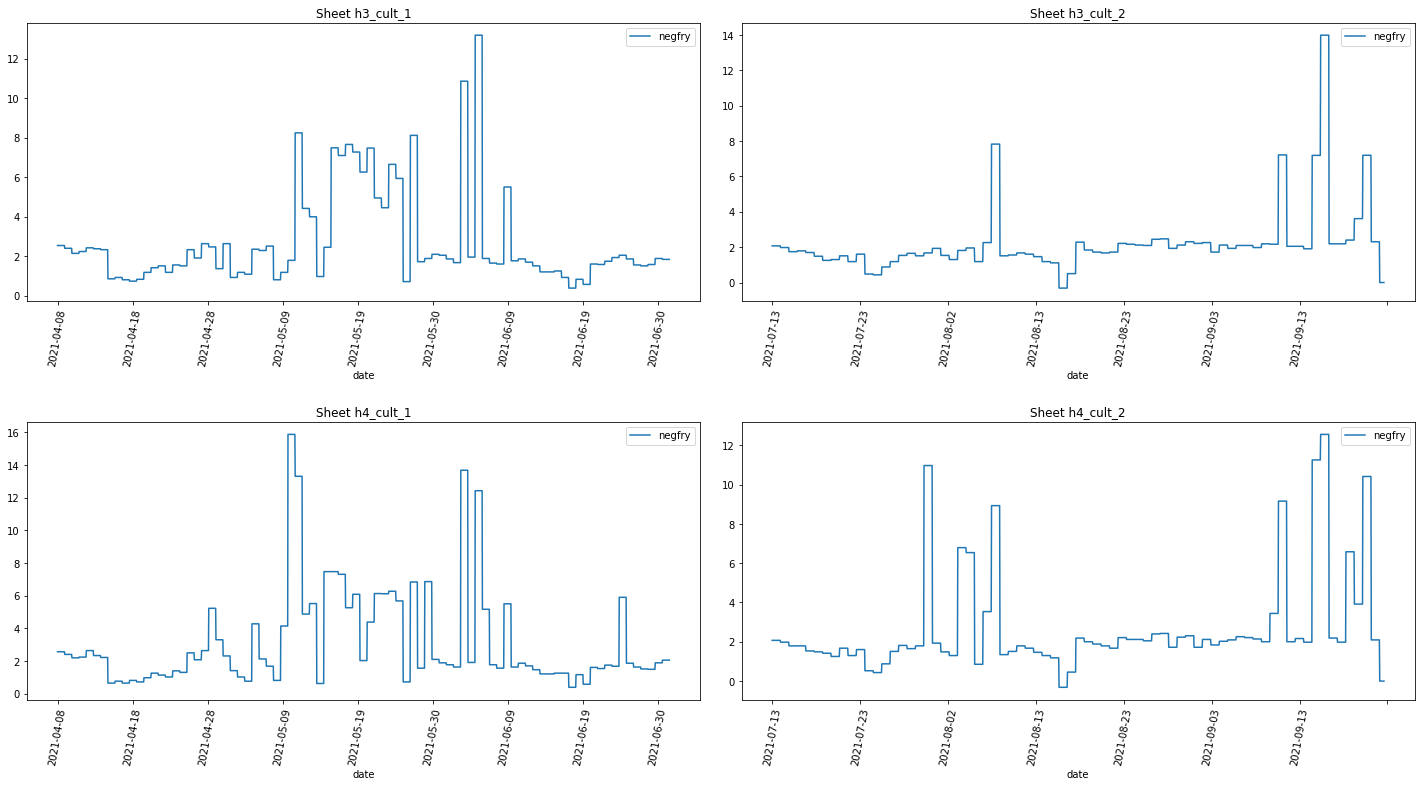

In [ ]:
# function to check the consecutive hours with humidity which is needed in the model
def ok_consecutive_humidity(df, i, hours_to_check):
    for j in range(hours_to_check):
        if len(df) <= i+j:
            return False
        if df.at[i+j, 'percent_humidity_avg'] < 90 and (not "precipitation_mm" in df or df.at[i+j, 'precipitation_mm'] == 0):
            return False
    return True

# Calculate the negfry model


def negfry_model(df):
    df['negfry'] = 0.0  # add column for our results

    r = [0.899, 0.4118, 0.5336, 0.8816, 1.0498, 0.5858,
         0.3924, 0.0702, 0.1278, 0.9108, 1.4706, 0.855, 0.1639, 0.0468]  # r constant
    h = np.zeros(14)  # h to update

    # consecutive humidity to know if we have to add a point or not to the h
    consecutive_humidity = 0
    for i, row in df.iterrows():
        # h13
        if row['air_temp_celsius_avg'] >= 15.0 and row['air_temp_celsius_avg'] <= 19.9:
            h[12] += 1
        # h14
        if row['percent_humidity_avg'] < 70:
            h[13] += 1

        # check prerequisites for h1 to h12
        if row['percent_humidity_avg'] >= 90 or ("precipitation_mm" in df and row['precipitation_mm'] >= 0.1):
            consecutive_humidity += 1

            # 4 consecutive, h1 to h6
            ok_humid = True
            if consecutive_humidity < 4:
                ok_humid = ok_consecutive_humidity(
                    df, i, 4 - consecutive_humidity)
            if ok_humid:
                if row['air_temp_celsius_avg'] >= 10.0 and row['air_temp_celsius_avg'] <= 11.9:
                    h[0] += 1
                if row['air_temp_celsius_avg'] >= 14.0 and row['air_temp_celsius_avg'] <= 15.9:
                    h[1] += 1
                if row['air_temp_celsius_avg'] >= 16.0 and row['air_temp_celsius_avg'] <= 17.9:
                    h[2] += 1
                if row['air_temp_celsius_avg'] >= 18.0 and row['air_temp_celsius_avg'] <= 19.9:
                    h[3] += 1
                if row['air_temp_celsius_avg'] >= 20.0 and row['air_temp_celsius_avg'] <= 21.9:
                    h[4] += 1
                if row['air_temp_celsius_avg'] >= 22.0 and row['air_temp_celsius_avg'] <= 23.9:
                    h[5] += 1

                # 10 consecutive, h7 to h12
                if consecutive_humidity < 10:
                    ok_consecutive_humidity(df, i, 10 - consecutive_humidity)
                if ok_humid:
                    if row['air_temp_celsius_avg'] >= 10.0 and row['air_temp_celsius_avg'] <= 11.9:
                        h[6] += 1
                    if row['air_temp_celsius_avg'] >= 14.0 and row['air_temp_celsius_avg'] <= 15.9:
                        h[7] += 1
                    if row['air_temp_celsius_avg'] >= 16.0 and row['air_temp_celsius_avg'] <= 17.9:
                        h[8] += 1
                    if row['air_temp_celsius_avg'] >= 18.0 and row['air_temp_celsius_avg'] <= 19.9:
                        h[9] += 1
                    if row['air_temp_celsius_avg'] >= 20.0 and row['air_temp_celsius_avg'] <= 21.9:
                        h[10] += 1
                    if row['air_temp_celsius_avg'] >= 22.0 and row['air_temp_celsius_avg'] <= 23.9:
                        h[11] += 1

        else:  # if it's not humid enough, cancel streak
            consecutive_humidity = 0

        # if end of the day
        if row['date'].endswith('23:00:00') or row['date'].endswith('23:00'):
            rh = (r * h)
            rh[12] += 7.5479
            rh[13] -= 7.8624
            df.at[i, 'negfry'] = rh.sum()  # calculate mildew risk
            df.loc[df['date'].str.startswith(row['date'].split(' ')[0]), [
                'negfry']] = df.at[i, 'negfry']  # update all rows of the day
            h = np.zeros(14)  # reset h to restart for the next day

for i, df in dfs.items():
    negfry_model(df)  # call model for each data

# Plot NegFry
plot_dfs(dfs, x="date", y="negfry")


## Caroline model
Prediction of infection = −11.5 + 0.28 * 𝑅𝐻80 + 0.34𝑑𝑇 (RH80: hours when RH > 80% over 24h period; dT: day temperature.)

2


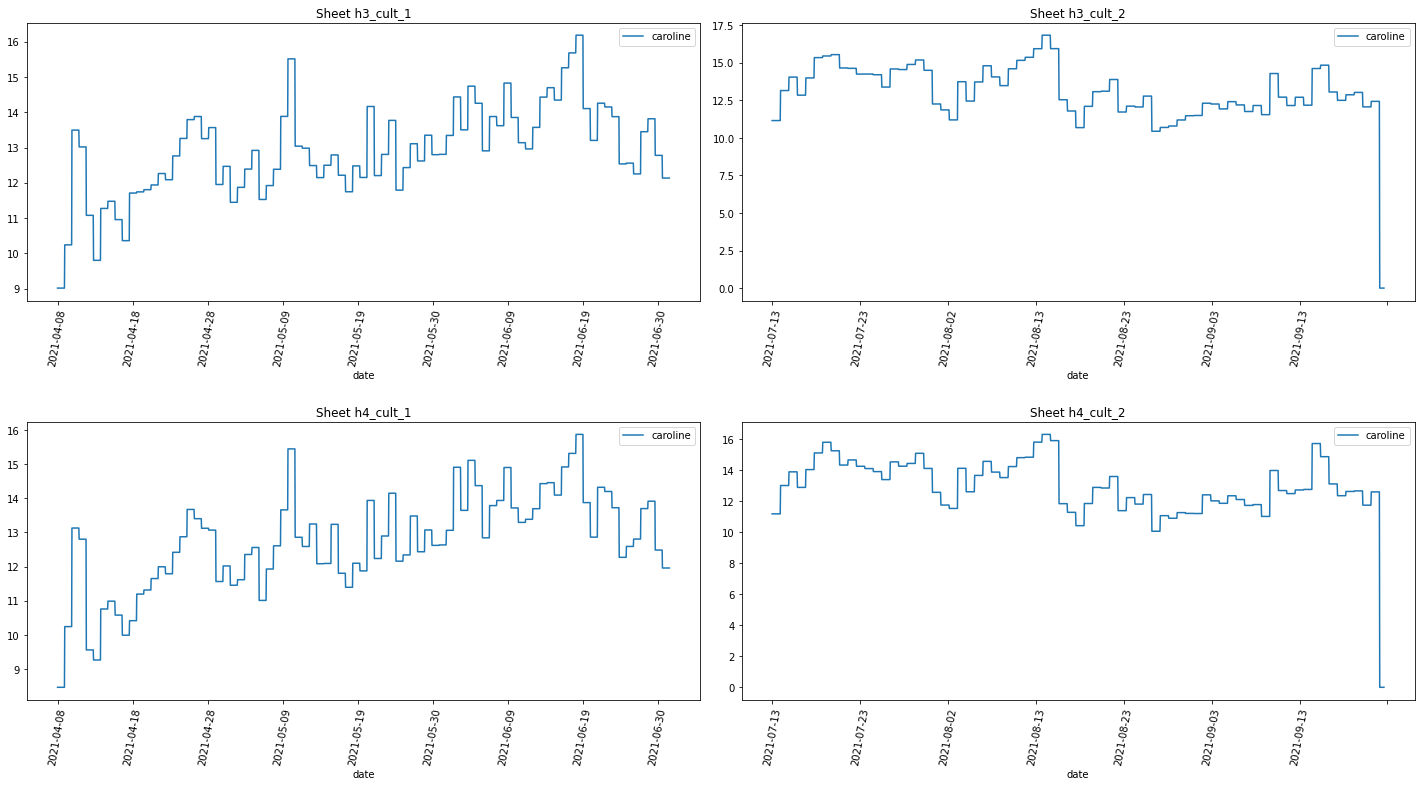

In [ ]:
# calculate the equation
def caroline_model(df):
    df['caroline'] = 0.0 # add a column for our results

    total_dt = 0.0 # avg temp of the day
    rh80 = 0 # hours when humidity > 80%
    n = 0 # n of hours (normally 24)

    for i, row in df.iterrows():

        n += 1
        total_dt += row['air_temp_celsius_avg']
        rh80 += row['percent_humidity_avg'] > 80

        # if end of the day
        if row['date'].endswith('23:00:00') or row['date'].endswith('23:00'):
            df.at[i, 'caroline'] = -11.5 + 0.28 * rh80 + 0.34 + total_dt / n # equation
            df.loc[df['date'].str.startswith(row['date'].split(' ')[0]), [
                'caroline']] = df.at[i, 'caroline'] # update all rows of the day

            # prepare next day
            n = 0
            total_dt = 0
            rh80 = 0

for i, df in dfs.items():
    caroline_model(df) # call model for each data

# Plot Caroline
plot_dfs(dfs, x="date", y="caroline")

## Conclusion
Let's save the models in csv, and do a subplot to consult all the result in the same windows and correlate them.

To use these models, they have to be adapted according to the results obtained on the field.

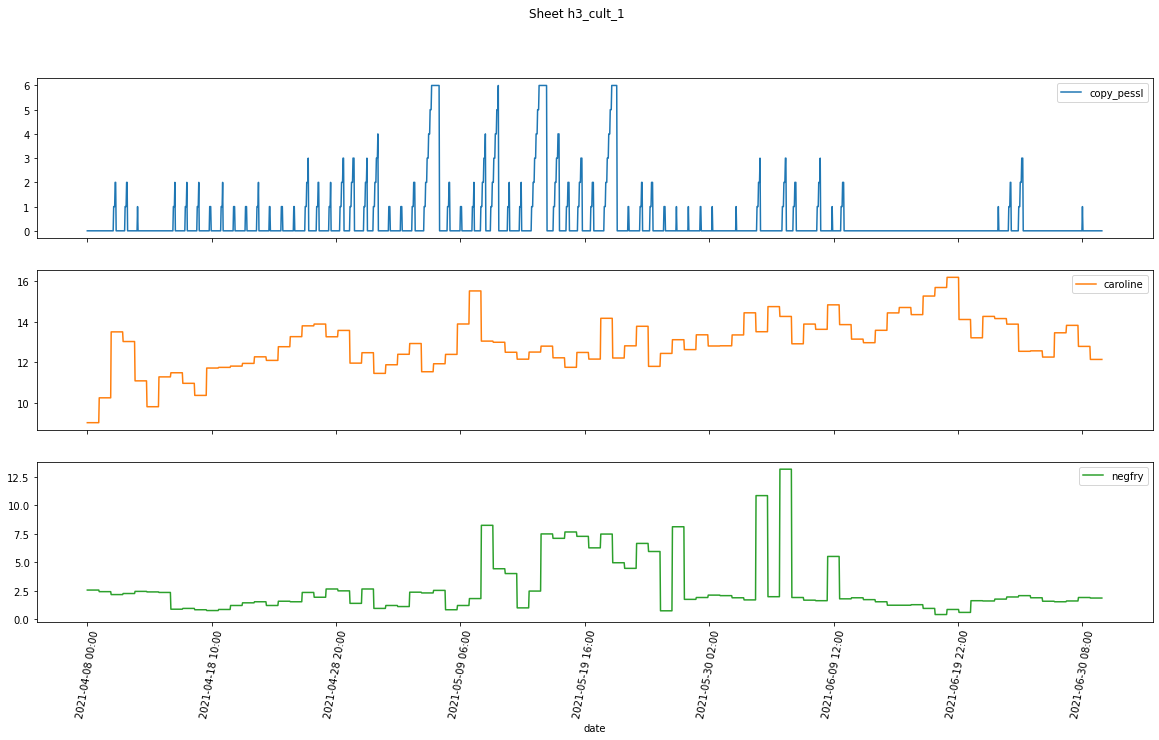

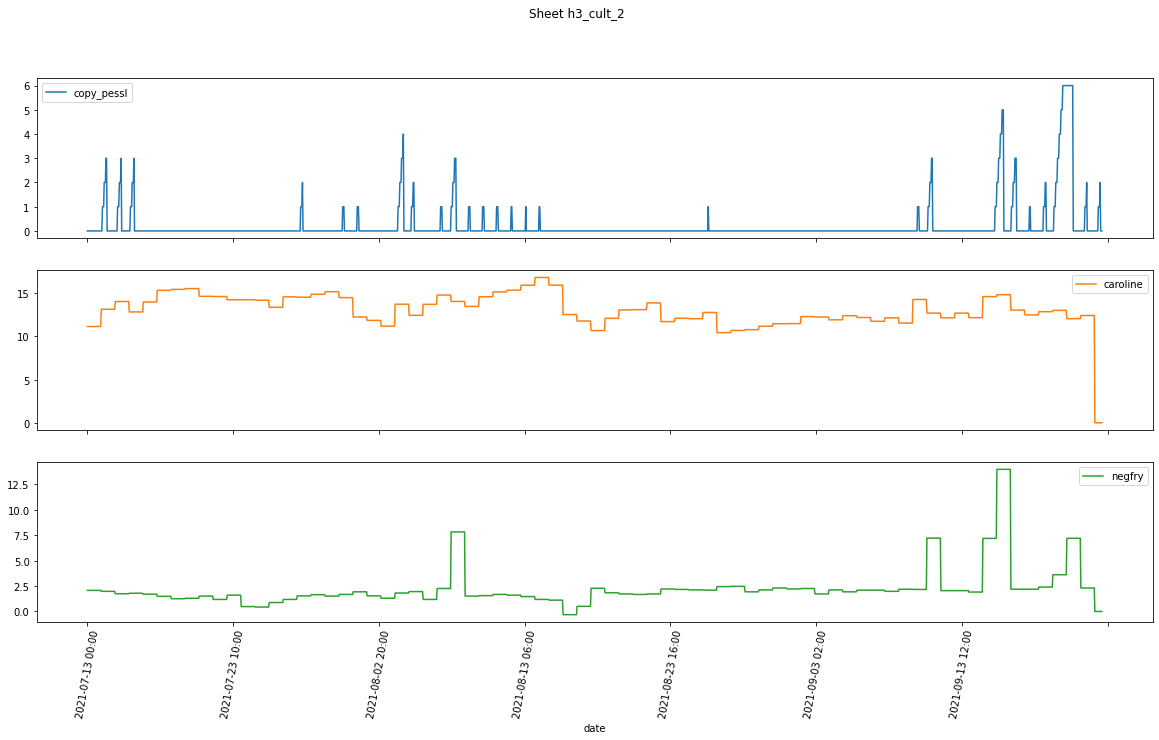

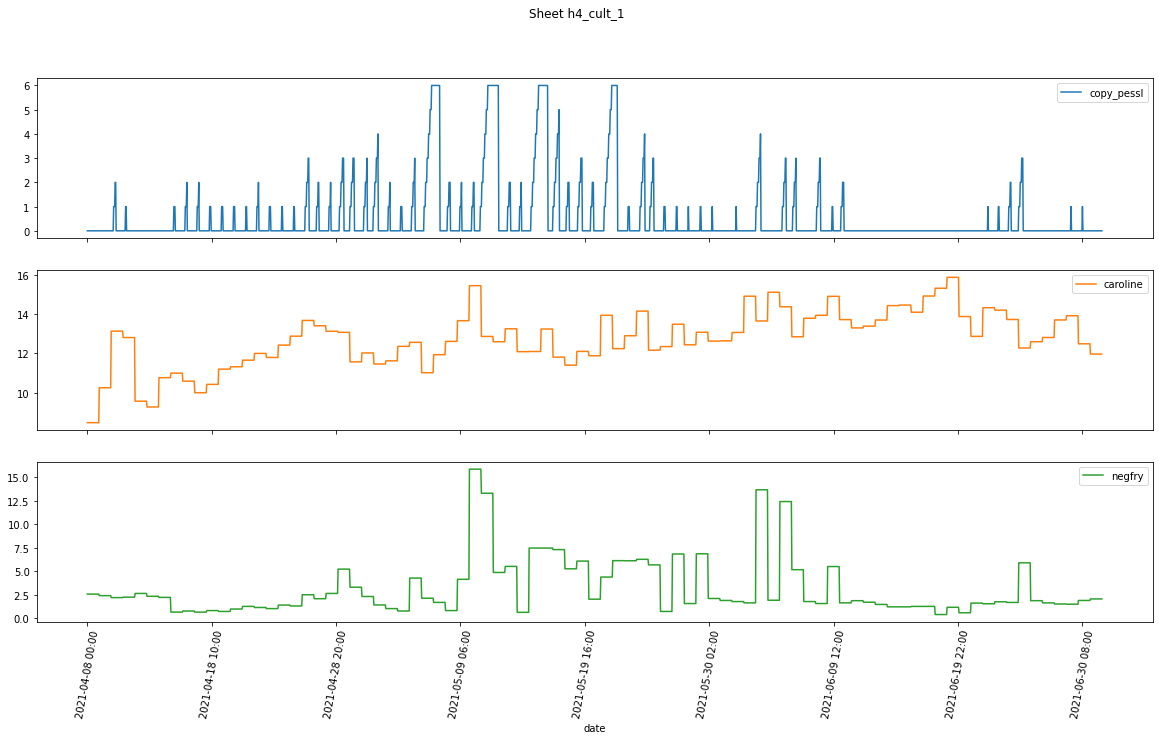

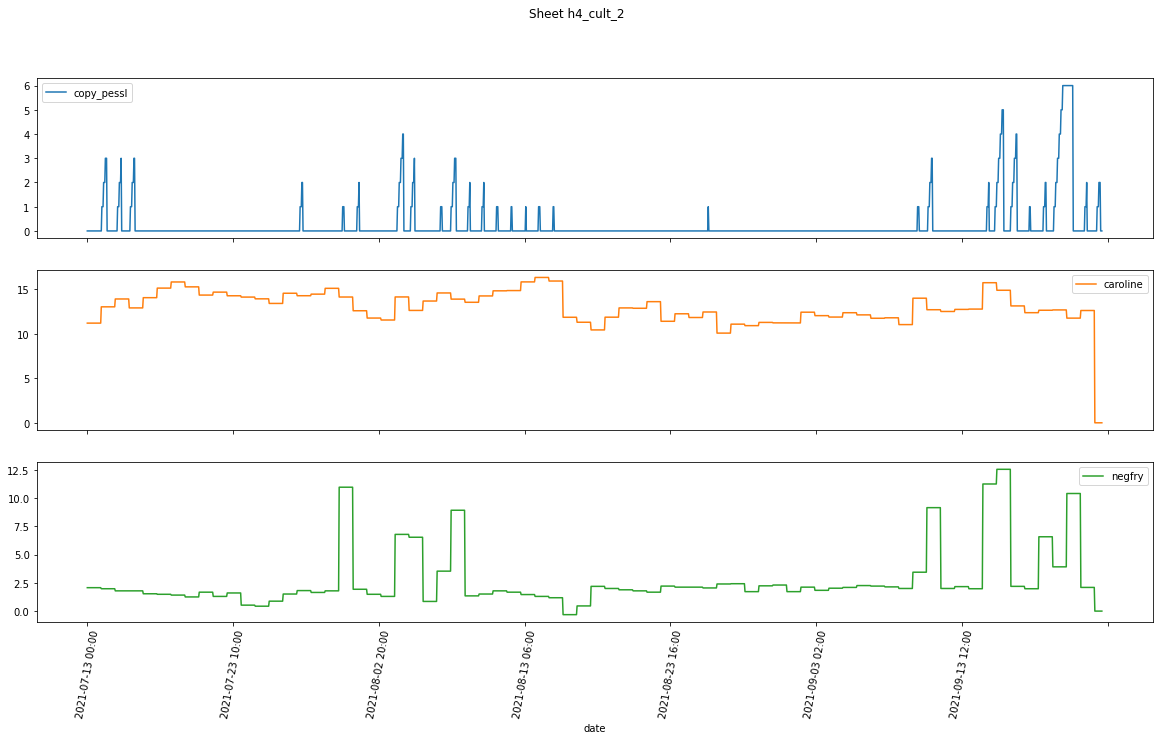

In [ ]:
df.to_csv('res_'+station+'.csv', index=False)

# For each data, show their models
for i, df in dfs.items():
    if "disease_severity" in df:
        df.plot(title="Sheet "+str(i), x="date", y=["disease_severity", "copy_pessl",
                                                    "caroline", "negfry"], subplots=True, rot=80)
    else:
        df.plot(title="Sheet "+str(i), x="date", y=["copy_pessl",
                                                    "caroline", "negfry"], subplots=True, rot=80)
